## Tangram multiome NC vs merscope NC

Zhiyuan Hu \
24 apr 2024 \
last modified 24 apr 2024

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
sys.path.append('./')  # uncomment for local import
import tangram as tg

%load_ext autoreload
%autoreload 2
%matplotlib inline

tg.__version__

/home/huzhiy/miniforge3/envs/tangram-env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.0.4'

## merscope NC vs multiome NC

### read spatial data

In [2]:
ad_sp = sc.read_h5ad('merscope/analysis/clustering_mapping/data/20240424_run1_minexp10_squidpy_adata.hdf5')
ad_sp = ad_sp[ (ad_sp.obs['leiden'].isin(['10','11','22','31']) ) ].copy()
ad_sp

AnnData object with n_obs × n_vars = 1545 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden', 'Cell_Type', 'Cluster'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'leiden', 'leiden_centrality_scores', 'leiden_colors', 'leiden_nhood_enrichment', 'leiden_ripley_L', 'log1p', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'blank_genes', 'spatial'
    varm: 'PCs

In [3]:
ad_sp.obs["leiden_broad"] = ad_sp.obs["leiden"]
ad_sp.obsm["X_umap_broad"] = ad_sp.obsm["X_umap"]

In [4]:
del ad_sp.obsm["X_umap"]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


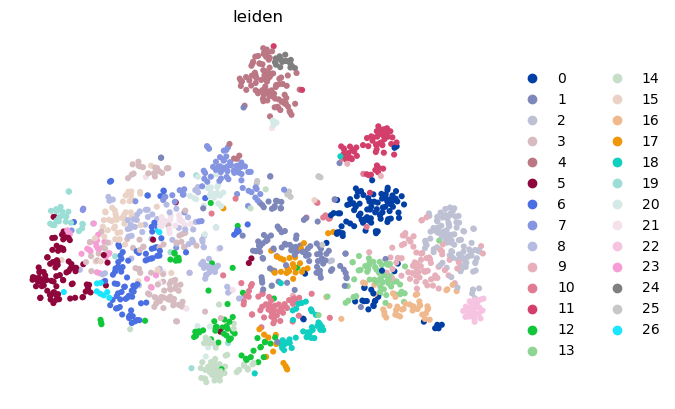

In [5]:
resolution = 1.5
sc.tl.pca(ad_sp, svd_solver='arpack')
sc.pp.neighbors(ad_sp, n_neighbors=5, n_pcs=16 )
sc.tl.tsne(ad_sp, perplexity = 16, learning_rate = 200)
sc.tl.leiden(ad_sp, resolution=resolution)
sc.pl.tsne(ad_sp, color= "leiden", frameon=False)

### Single cell data

In [6]:
path = os.path.join('multiome/analysis_newref/velocity',"data/seurat/seu_RNAsoupx_NC.h5ad")
ad_sc = sc.read_h5ad(path)
ad_sc.var.index = ad_sc.var["_index"]
ad_sc

AnnData object with n_obs × n_vars = 16550 × 27599
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample_id', 'sample', 'stage', 'genotype', 'DoubletFinder', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'DoubletScore', 'DoubletEnrichment', 'BlacklistRatio', 'demuxlet_singlet', 'RNA_snn_res.0.6', 'seurat_clusters', 'major_clusters', 'NTorNC', 'RNA_snn_res.0.8', 'major_clusters_NTnNC', 'RNA_snn_res.1', 'genotype_new', 'S.Score', 'G2M.Score', 'Phase', 'cell_type'
    var: '_index', 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [7]:
ad_sc = ad_sc[ (ad_sc.obs['genotype_new'] == 'cit') & (ad_sc.obs['stage'].isin([1, 2, 3])) ].copy()

In [29]:
# Replace all occurrences of 'dNC_nohox_cycling' with 'dNC_nohox' in the 'cell_type' column
ad_sc.obs['cell_type'] = ad_sc.obs['cell_type'].replace('dNC_nohox_cycling', 'dNC_nohox')
ad_sc.obs['cell_type'] = ad_sc.obs['cell_type'].replace('NPB_nohox_cycling', 'NPB_nohox')
ad_sc = ad_sc[ ~ad_sc.obs['cell_type'].isin(["Mutant_hox2","Mutant_nohox_early"])].copy()

In [9]:
np.unique(ad_sc.X.toarray()[0, :])

array([0.00000000e+00, 2.00060634e-02, 9.30038549e-02, ...,
       8.47008704e+01, 1.18548189e+02, 2.28533380e+02])

In [10]:
sc.pp.normalize_total(ad_sc)

### Prepare to map

In [30]:
sc.pp.filter_genes(ad_sc, min_cells=1)
sc.pp.filter_genes(ad_sp, min_cells=1)

ad_sc.var.index = [g.lower() for g in ad_sc.var.index]
ad_sp.var.index = [g.lower() for g in ad_sp.var.index]

In [31]:
markers = ad_sp.var_names
markers = list(markers)
len(markers)

300

In [32]:
tg.pp_adatas(ad_sc, ad_sp, genes=markers)

300 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
300 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [33]:
ad_sp.var.index 

Index(['dlx2a', 'foxc1a', 'postnb', 'grem2b', 'bhlhe40', 'foxd3', 'tfec',
       'mitfa', 'itga3a', 'cadm1a',
       ...
       'wnt8b', 'diaph3', 'dld', 'tbx6', 'itm2cb', 'pax6b', 'fhl2a', 'gata5',
       'gata1a', 'twist1b'],
      dtype='object', length=300)

### Map
(below is copied from https://github.com/broadinstitute/Tangram/blob/master/tutorial_tangram_without_squidpy.ipynb)

In [34]:
adata_sc=ad_sc
adata_sp=ad_sp
genes=None
gene_to_lowercase=True
# remove all-zero-valued genes
sc.pp.filter_genes(adata_sc, min_cells=1)
sc.pp.filter_genes(adata_sp, min_cells=1)

if genes is None:
    # Use all genes
    genes = adata_sc.var.index
           
# put all var index to lower case to align
if gene_to_lowercase:
    adata_sc.var.index = [g.lower() for g in adata_sc.var.index]
    adata_sp.var.index = [g.lower() for g in adata_sp.var.index]
    genes = list(g.lower() for g in genes)

adata_sc.var_names_make_unique()
adata_sp.var_names_make_unique()


# Refine `marker_genes` so that they are shared by both adatas
genes = list(set(genes) & set(adata_sc.var.index) & set(adata_sp.var.index))
# logging.info(f"{len(genes)} shared marker genes.")

adata_sc.uns["training_genes"] = genes
adata_sp.uns["training_genes"] = genes

In [35]:
#genes

In [36]:
ad_map = tg.map_cells_to_space(
    adata_sc=ad_sc,
    adata_sp=ad_sp,
    cv_train_genes=genes,
    device='cpu',
    mode='clusters',
    learning_rate = 0.01,
    cluster_label='cell_type',
    density_prior='uniform' # density_prior specifies the cell density within each spatial voxel. Use uniform if the spatial voxels are at single cell resolution (ie MERFISH). 
)

Allocate tensors for mapping.
Begin training with 300 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.
Score: 0.003, KL reg: 0.071
Score: 0.049, KL reg: 0.004
Score: 0.091, KL reg: 0.003
Score: 0.115, KL reg: 0.003
Score: 0.125, KL reg: 0.003
Score: 0.129, KL reg: 0.003
Score: 0.130, KL reg: 0.003
Score: 0.131, KL reg: 0.003
Score: 0.132, KL reg: 0.003
Score: 0.133, KL reg: 0.003
Saving results..


### Downstream analysis

In [37]:
ad_sp

AnnData object with n_obs × n_vars = 1545 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden', 'Cell_Type', 'Cluster', 'leiden_broad', 'uniform_density', 'rna_count_based_density', 'dNC_nohox', 'mNC_nohox', 'mNC_arch1', 'Pigment_sox6_high', 'mNC_head_mesenchymal', 'mNC_arch2', 'mNC_hox34', 'dNC_hoxa2b', 'Pigment_gch2_high', 'dNC_hox34', 'mNC_vagal', 'NPB_hox3', 'NPB_nohox', 'NC_trunk', 'Mutant_nohox_early', 'NPB_hox2', 'Mutant_nohox_12_22ss', 'Mutant_hox2'
    var: 'n_cells_by_counts', 'mean

In [38]:
tg.project_cell_annotations(ad_map, ad_sp, annotation='cell_type')
annotation_list = list(pd.unique(ad_sc.obs['cell_type']))
annotation_list[1:10]

spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


['Pigment_gch2_high',
 'mNC_head_mesenchymal',
 'Pigment_sox6_high',
 'mNC_arch1',
 'mNC_hox34',
 'mNC_vagal',
 'mNC_nohox',
 'NC_trunk',
 'Mutant_nohox_12_22ss']

In [41]:
ad_sp.obs = ad_sp.obs[['fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy',
       'transcript_count', 'perimeter_area_ratio', 'solidity',
       'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw',
       'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass',
       'Cellbound3_raw', 'Cellbound3_high_pass', 'DAPI_raw', 'DAPI_high_pass',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_300_genes', 'n_counts', 'leiden', 'Cell_Type',
       'Cluster', 'leiden_broad', 'uniform_density', 'rna_count_based_density']]

In [42]:
ad_sp.obs = ad_sp.obs.join(ad_sp.obsm["tangram_ct_pred"])
ad_sp.obs

,fov,volume,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,...,mNC_hox34,dNC_hoxa2b,dNC_hox34,Pigment_gch2_high,mNC_vagal,NPB_hox3,NPB_nohox,NC_trunk,NPB_hox2,Mutant_nohox_12_22ss
1705254700003100462_region_0,17,1961.584547,4790.531730,7128.891936,4806.522297,7142.779582,1.277381,93,0.297543,7.795818,...,0.000111,0.000015,0.000626,0.000012,0.000036,0.000006,2.421895e-06,1.531161e-06,1.421485e-06,0.000002
1705254700003100515_region_0,16,2281.419564,4792.635974,7156.590534,4809.006161,7171.618518,1.223348,85,0.270672,7.763119,...,0.000003,0.000011,0.000049,0.000106,0.000011,0.000005,2.374800e-06,1.854565e-06,2.219470e-02,0.000002
1705254700003100530_region_0,16,1292.103057,4804.553874,7166.824686,4818.123386,7177.790003,1.334072,98,0.355545,7.933256,...,0.000003,0.000006,0.000002,0.000006,0.000006,0.000017,4.384790e-06,8.115696e-07,4.245269e-06,0.000027
1705254700003100543_region_0,21,2430.102229,4775.339233,7171.342343,4794.265444,7186.122988,1.359623,100,0.268008,7.723672,...,0.000027,0.000005,0.000006,0.000047,0.000025,0.000001,1.445994e-05,3.934862e-06,6.840108e-06,0.000004
1705254700003100552_region_0,21,1410.633089,4759.328159,7175.752254,4768.114379,7195.103847,2.208035,65,0.404067,7.492227,...,0.000129,0.000107,0.000033,0.000367,0.000007,0.000007,1.398181e-05,3.322958e-06,1.706605e-05,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1705260600008100496_region_9,548,1581.337324,772.708986,1596.542843,787.303202,1608.019988,1.411193,139,0.348146,7.485570,...,0.001432,0.000029,0.000006,0.000027,0.000001,0.000004,5.643006e-07,6.801442e-05,7.666010e-06,0.000087
1705260600008100508_region_9,536,1846.635168,829.807792,1615.277610,847.327373,1629.714714,1.166286,295,0.314356,7.714860,...,0.000022,0.000129,0.000091,0.000049,0.000003,0.000001,3.781981e-06,1.916161e-06,6.254912e-06,0.000009
1705260600008200346_region_9,537,1288.491586,893.279261,1549.992999,906.698755,1565.578718,1.881831,306,0.415713,7.257650,...,0.001278,0.000110,0.002962,0.000016,0.002848,0.002414,4.847107e-07,1.520211e-05,7.897119e-07,0.000002
1705260600008200348_region_9,537,438.954255,890.352898,1549.927023,896.240268,1560.224598,2.184689,115,0.714481,7.510652,...,0.000099,0.002722,0.000923,0.000200,0.000146,0.007159,1.835705e-06,1.651615e-02,6.383506e-05,0.000057


In [43]:
ad_sp

AnnData object with n_obs × n_vars = 1545 × 300
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'Cellbound2_raw', 'Cellbound2_high_pass', 'Cellbound1_raw', 'Cellbound1_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'Cellbound3_raw', 'Cellbound3_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'leiden', 'Cell_Type', 'Cluster', 'leiden_broad', 'uniform_density', 'rna_count_based_density', 'dNC_nohox', 'mNC_nohox', 'mNC_arch1', 'Pigment_sox6_high', 'mNC_head_mesenchymal', 'mNC_arch2', 'mNC_hox34', 'dNC_hoxa2b', 'dNC_hox34', 'Pigment_gch2_high', 'mNC_vagal', 'NPB_hox3', 'NPB_nohox', 'NC_trunk', 'NPB_hox2', 'Mutant_nohox_12_22ss'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_d

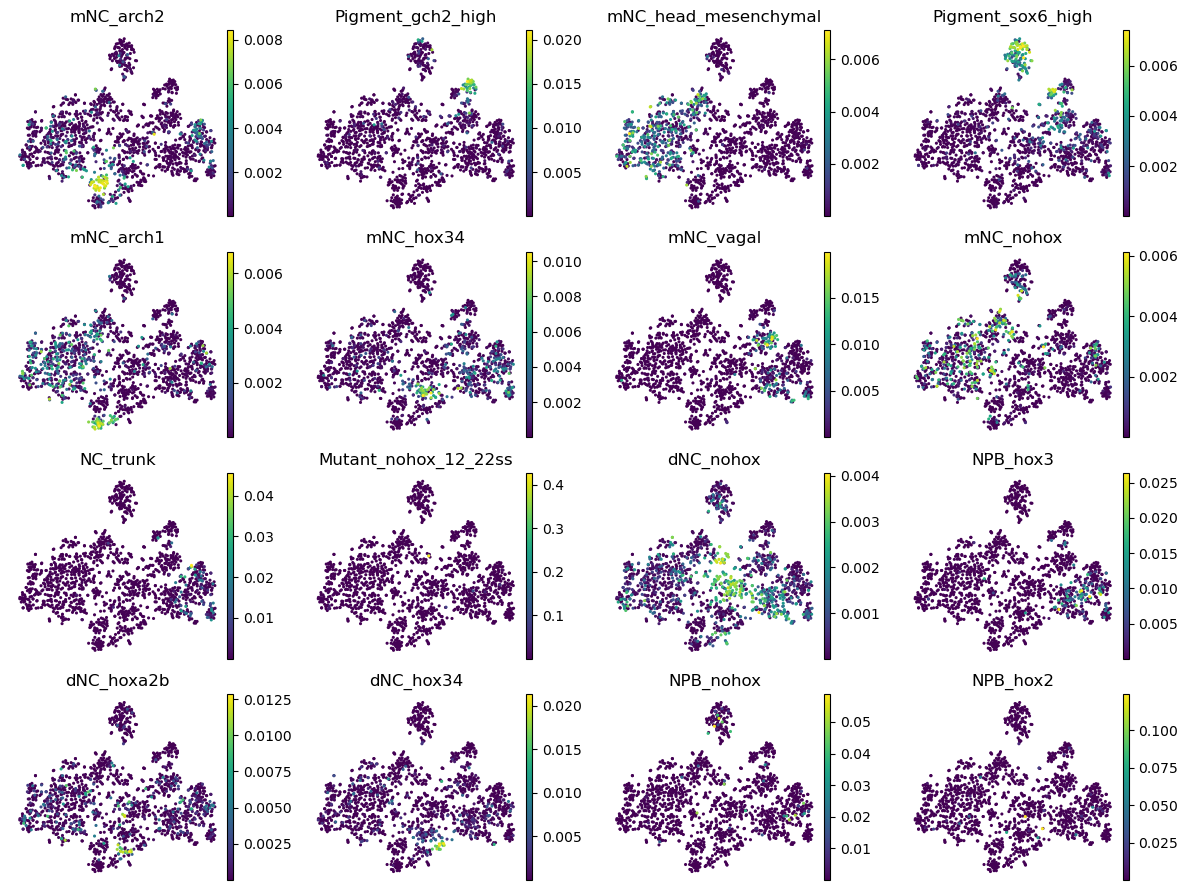

In [50]:
# Define the number of plots based on the length of annotation_list
n_plots = len(annotation_list)
n_cols = int(np.ceil(n_plots / 4))  # Calculate columns needed for 6 rows
fig, axs = plt.subplots(4, n_cols, figsize=(n_cols * 3, 9))  # Adjust the width and height as per number of plots

# Loop through each annotation and plot on the respective axis
for i, annotation in enumerate(annotation_list):
    size = 20 if i == 0 else 20  # First plot has size 20, others have size 10
    row = i // n_cols  # Determine the row of the subplot
    col = i % n_cols   # Determine the column of the subplot
    ax = axs[row, col] if n_cols > 1 else axs[row]  # Adjust indexing based on number of columns
    sc.pl.tsne(ad_sp, color=annotation, size=size, frameon=False, show=False, ax=ax)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()  # Display the plot at the end

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the matrix you want to plot
data_matrix = ad_sp.obsm["tangram_ct_pred"]
data_matrix['Cluster'] = ad_sp.obs['leiden']
# Aggregate data by clusters, calculating the mean for each feature within each cluster
cluster_means = data_matrix.groupby('Cluster').mean()

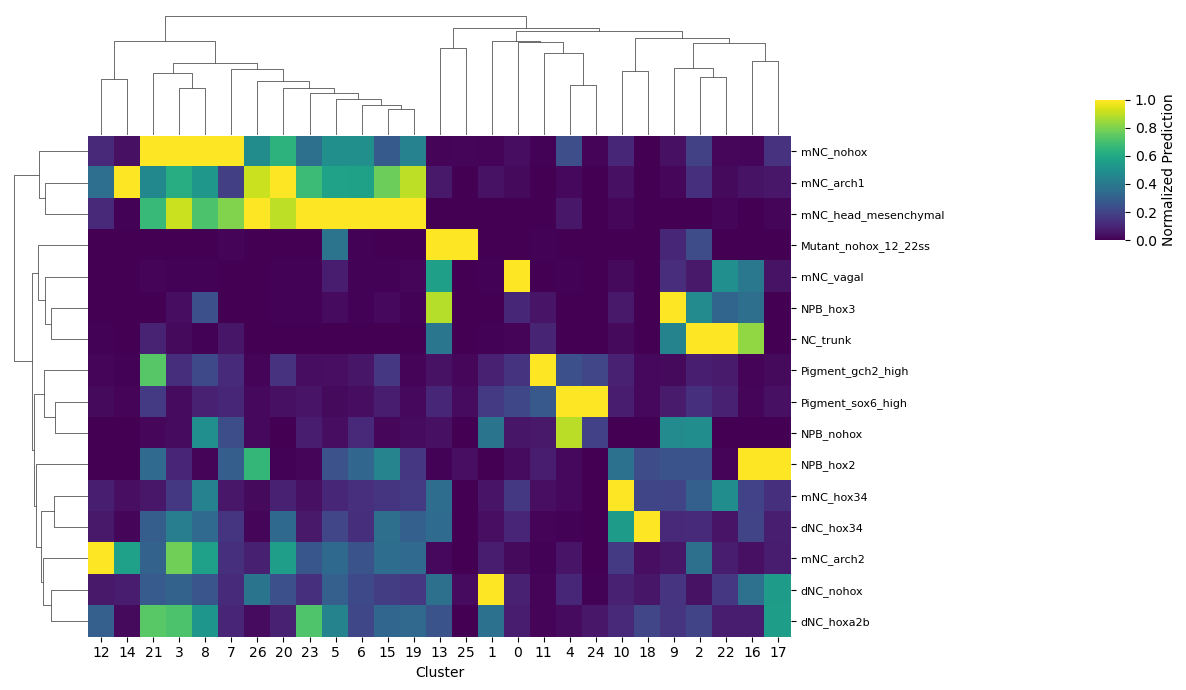

In [46]:
# Normalize each row by its maximum and minimum values
row_scaled = cluster_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Plotting the heatmap of row-scaled data
# Using seaborn's clustermap to cluster rows and columns and plot with dendrograms
g = sns.clustermap(row_scaled.transpose(), method='average', metric='euclidean', cmap='viridis', 
                   figsize=(10, 7), row_cluster=True, col_cluster=True,
                   cbar_kws={'label': 'Normalized Prediction'},
                   dendrogram_ratio=(.1, .2), # Adjust dendrogram size
                   cbar_pos=(1.1, 0.65, 0.03, 0.2))  # Adjust colorbar position

# Adjusting font size for y-tick labels to ensure visibility
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)  # Adjust font size as needed


# Show the plot
plt.show()

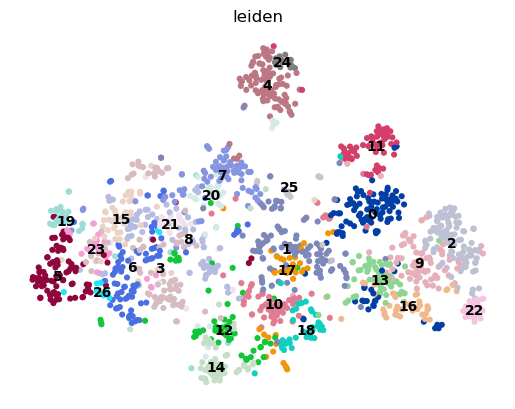

In [47]:
sc.pl.tsne(ad_sp, color= "leiden", frameon=False, legend_loc="on data")

## save data

In [51]:
ad_sp.write_h5ad("merscope/analysis/clustering_mapping/results/run1/run1_tangram_out_NConly_20240424.h5ad")